<a href="https://colab.research.google.com/github/gokulanv/ToyFederatedLearning/blob/master/FederatedLearning/RemoteFL_MNISTData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# F Learning

### Idea:
Instead of having the data locally and training the model based on the local data, Federated learning pushes the model to where the data resides and trains the model remotely and sends the updates back to the centralized server.

In [3]:
pip install syft

  Using cached https://files.pythonhosted.org/packages/43/29/3fd78b6cecc540ebb31e676d269787d4bf5b4b90e479474a4f5ec9744bc0/syft-0.2.6-py3-none-any.whl
     |████████████████████████████████| 753.4MB 18kB/s 
     |████████████████████████████████| 450kB 48.0MB/s 
     |████████████████████████████████| 2.1MB 45.9MB/s 
  Using cached https://files.pythonhosted.org/packages/bb/d9/856af84843912e2853b1b6e898ac8b802989fcf9ecf8e8445a1da263bf3b/websockets-8.1-cp36-cp36m-manylinux2010_x86_64.whl
     |████████████████████████████████| 1.8MB 47.6MB/s 
  Using cached https://files.pythonhosted.org/packages/7e/90/6141bf41f5655c78e24f40f710fdd4f8a8aff6c8b7c6f0328240f649bdbe/torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl
     |████████████████████████████████| 204kB 38.1MB/s 
  Using cached https://files.pythonhosted.org/packages/32/0e/568e97b014eb14e794a1258a341361e9da351dc6240c63b89e1541e3341c/phe-1.4.0.tar.gz
     |████████████████████████████████| 2.0MB 45.7MB/s 
     |███████████████████████

### Remote Execution in PySyft

The essence of Federated Learning is the ability to train models in parallel on a wide number of machines. Thus, we need the ability to tell remote machines to execute the operations required for Deep Learning.

Thus, instead of using Torch tensors - we're now going to work with pointers to tensors. Say we are executing remotely on my machine.

In [0]:
import syft as sy
import torch
hook = sy.TorchHook(torch)

##### Properties

In [11]:
gok = sy.VirtualWorker(hook, id="gok")
print(gok._objects)

prof = sy.VirtualWorker(hook, id="prof")
print(gok._objects)


x = torch.tensor([1,2,3,4,5])
x = x.send(gok)
gok._objects, x.location, x.id_at_location, x.id, x.owner, hook.local_worker, x

{38196090708: tensor([[1., 1.],
        [0., 1.]], requires_grad=True), 97787146248: tensor([[1.],
        [1.]], requires_grad=True)}
{38196090708: tensor([[1., 1.],
        [0., 1.]], requires_grad=True), 97787146248: tensor([[1.],
        [1.]], requires_grad=True)}


({38196090708: tensor([[1., 1.],
          [0., 1.]], requires_grad=True),
  92021371233: tensor([1, 2, 3, 4, 5]),
  97787146248: tensor([[1.],
          [1.]], requires_grad=True)},
 <VirtualWorker id:gok #objects:3>,
 92021371233,
 82815723811,
 <VirtualWorker id:me #objects:0>,
 <VirtualWorker id:me #objects:0>,
 (Wrapper)>[PointerTensor | me:82815723811 -> gok:92021371233])

In [6]:
x = x.get()
gok._objects

{}

### Toy Learning

Lets fit a model to distinguish simple linearly differentiable data \\
Scenario 1: Server training

In [9]:
from torch import nn, optim

# Toy Dataset
data = torch.tensor([[1.,1],[0,1],[1,0],[0,0]], requires_grad=True)
target = torch.tensor([[1.],[1], [0], [0]], requires_grad=True)

model = nn.Linear(2,1)

opt = optim.SGD(params=model.parameters(), lr=0.1)

def train(iterations=20):

    for iter in range(iterations):
        opt.zero_grad()
        pred = model(data)
        loss = ((pred - target)**2).sum()
        loss.backward()
        opt.step()
        print(loss.data)
        
train()

tensor(7.3795)
tensor(2.0015)
tensor(1.0764)
tensor(0.6738)
tensor(0.4303)
tensor(0.2755)
tensor(0.1765)
tensor(0.1131)
tensor(0.0725)
tensor(0.0464)
tensor(0.0298)
tensor(0.0191)
tensor(0.0123)
tensor(0.0079)
tensor(0.0051)
tensor(0.0032)
tensor(0.0021)
tensor(0.0013)
tensor(0.0009)
tensor(0.0006)


Scenario 2: Remote On-devices training

In [12]:
data_gok = data[0:2].send(gok)
target_gok = target[0:2].send(gok)

data_prof = data[2:4].send(prof)
target_prof = target[2:4].send(prof)


datasets = [(data_gok, target_gok), (data_prof, target_prof)]

def train(iterations=20):

    model = nn.Linear(2,1)
    opt = optim.SGD(params=model.parameters(), lr=0.1)
    
    for iter in range(iterations):

        for _data, _target in datasets:

            # send model to data on-device location
            model = model.send(_data.location)

            # do normal training
            opt.zero_grad()
            pred = model(_data)
            loss = ((pred - _target)**2).sum()
            loss.backward()
            opt.step()

            # get smarter model back
            model = model.get()

            print(loss.get())
            
train()

tensor(4.0678, requires_grad=True)
tensor(0.6259, requires_grad=True)
tensor(0.5441, requires_grad=True)
tensor(0.4290, requires_grad=True)
tensor(0.2923, requires_grad=True)
tensor(0.2539, requires_grad=True)
tensor(0.1773, requires_grad=True)
tensor(0.1501, requires_grad=True)
tensor(0.1094, requires_grad=True)
tensor(0.0898, requires_grad=True)
tensor(0.0683, requires_grad=True)
tensor(0.0545, requires_grad=True)
tensor(0.0432, requires_grad=True)
tensor(0.0337, requires_grad=True)
tensor(0.0276, requires_grad=True)
tensor(0.0212, requires_grad=True)
tensor(0.0180, requires_grad=True)
tensor(0.0137, requires_grad=True)
tensor(0.0118, requires_grad=True)
tensor(0.0091, requires_grad=True)
tensor(0.0079, requires_grad=True)
tensor(0.0062, requires_grad=True)
tensor(0.0054, requires_grad=True)
tensor(0.0043, requires_grad=True)
tensor(0.0037, requires_grad=True)
tensor(0.0030, requires_grad=True)
tensor(0.0026, requires_grad=True)
tensor(0.0022, requires_grad=True)
tensor(0.0018, requi

### Federated LEarning on Fashion MNIST data

In [14]:

from torchvision import datasets, transforms

import torch 
import syft as sy
import copy
from torch import nn, optim
import numpy as np
import math
import logging
from torch.utils.data import Dataset

hook = sy.TorchHook(torch)

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


tensor(3)


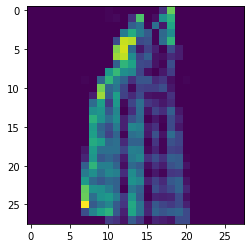

In [15]:
import matplotlib.pyplot as plt
image, label = next(iter(trainloader))
plt.imshow(image[0,:][0]);
print(label[0])

#### Custom Federated Learning dataset

In [0]:
gok = sy.VirtualWorker(hook, id ="gok")
prof = sy.VirtualWorker(hook, id="prof")

logger = logging.getLogger(__name__)
def dataset_federate(dataset, workers):
    logger.info("Scanning and sending data to {}...".format(", ".join([w.id for w in workers])))

    data_size = math.ceil(len(dataset) / len(workers))

    datasets = []
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=data_size, drop_last=True)
    for dataset_idx, (data, targets) in enumerate(data_loader):
        worker = workers[dataset_idx % len(workers)]
        logger.debug("Sending data to worker %s", worker.id)
        data = data.send(worker)
        targets = targets.send(worker)
        datasets.append(sy.BaseDataset(data, targets))  # .send(worker)

    logger.debug("Done!")
    return sy.FederatedDataset(datasets)

federated_train_loader = sy.FederatedDataLoader(
    dataset_federate(
        trainset,(gok, prof)
        ), 
    batch_size=64, 
    shuffle=True)


#### Model Config

In [0]:
model = nn.Sequential(
                    nn.Linear(784,128),
                    nn.ReLU(),
                    nn.Linear(128,64),
                    nn.ReLU(),
                    nn.Linear(64,10),
                    nn.LogSoftmax(dim=1)
                    )

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0005)

#### Training

In [19]:
for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader):
        data = data.view(data.shape[0], -1)
        model.send(data.location)
        output = model(data)
        data, target = data.to('cpu'), target.to('cpu')
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.get()
        if batch_idx % 30 == 0:
            loss = loss.get() 
            print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))
    model.eval()
    print('Epoch: ', epoch)
    total_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(testloader):
        data = data.view(data.shape[0], -1)
        output = model(data)
        
        loss = criterion(output, target)
        print('Loss: ', loss.item())
        max_arg_output = torch.argmax(output, dim=1)
        total_correct += int(torch.sum(max_arg_output == target))
        total += data.shape[0]
    print('Testing data accuracy: {:.0%}'.format(total_correct/total))

Train Epoch: 0 Loss: 2.295417
Train Epoch: 0 Loss: 2.303848
Train Epoch: 0 Loss: 2.304167
Train Epoch: 0 Loss: 2.319456
Train Epoch: 0 Loss: 2.303140
Train Epoch: 0 Loss: 2.295700
Train Epoch: 0 Loss: 2.280747
Train Epoch: 0 Loss: 2.282676
Train Epoch: 0 Loss: 2.246487
Train Epoch: 0 Loss: 2.257097
Train Epoch: 0 Loss: 2.258925
Train Epoch: 0 Loss: 2.260521
Train Epoch: 0 Loss: 2.253984
Train Epoch: 0 Loss: 2.254073
Train Epoch: 0 Loss: 2.229182
Train Epoch: 0 Loss: 2.257481
Train Epoch: 0 Loss: 2.231812
Train Epoch: 0 Loss: 2.243870
Train Epoch: 0 Loss: 2.219320
Train Epoch: 0 Loss: 2.200479
Train Epoch: 0 Loss: 2.223818
Train Epoch: 0 Loss: 2.216469
Train Epoch: 0 Loss: 2.209219
Train Epoch: 0 Loss: 2.204651
Train Epoch: 0 Loss: 2.185333
Train Epoch: 0 Loss: 2.185384
Train Epoch: 0 Loss: 2.183397
Train Epoch: 0 Loss: 2.170432
Train Epoch: 0 Loss: 2.162330
Train Epoch: 0 Loss: 2.155714
Train Epoch: 0 Loss: 2.156548
Train Epoch: 0 Loss: 2.149725
Epoch:  0
Loss:  2.149935245513916
Loss: